In [1]:
import gc
import csv
import numpy as np
import matplotlib.pyplot as plt
from utils import save_results
from models import least_squares, gradient_descent
from preprocessing import (features_expansion, features_selection,
                                    get_initial_df, preparation, splitting)
from visualization import snr_plot, y_compare
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [2]:
OUTPUT_FILE = "results.csv"

In [3]:
df_spectra, df_measures, df_tts = get_initial_df('data')
meta_cols = ['SiteCode', 'Date', 'flag',
             'Latitude', 'Longitude']
unc_col = 'DUSTf:Unc'
y_col = 'DUSTf:Value'

In [4]:
merged = preparation(df_spectra, df_measures, meta_cols, unc_col, y_col)
%xdel df_spectra
%xdel df_measures
print("Shape: merged: {}".format(merged.shape))

Shape: merged: (18001, 2791)


In [ ]:
tx_train, y_train, _, tx_test, y_test, unc_test = splitting(merged,df_tts,meta_cols,unc_col,y_col)
print("Shapes:\n\ttx_train: {}\n\ty_train: {}\n\ttx_test: {}\n\ty_test: {}".format(tx_train.shape, y_train.shape, tx_test.shape, y_test.shape))
%xdel merged
%xdel df_tts

Shapes:
	tx_train: (13357, 2784)
	y_train: (13357,)
	tx_test: (4644, 2784)
	y_test: (4644,)


In [ ]:
gd_initial_weights = np.random.rand(tx_train.shape[1])
print(gd_initial_weights.shape)

(2784,)


In [ ]:
with open(OUTPUT_FILE, "w") as f:
    writer = csv.writer(f)
    writer.writerow(["methos", 'w', 'loss'])

# Methods

## BASELINE

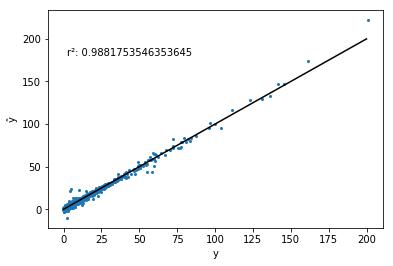

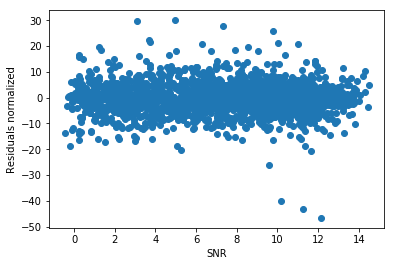

In [ ]:
loss, weights_baseline = least_squares(tx_train, y_train, tx_test, y_test)
save_results(OUTPUT_FILE, "simple least squares", weights_baseline, loss)
y_compare(tx_test, y_test, weights_baseline, "baseline_y-compare_simple.png")
snr_plot(tx_test, y_test, weights_baseline, unc_test, "baseline_snr_simple.png")

## Gradient descent

Iteration 0, loss is 1346.6001644777007
Iteration 100, loss is 83.80277809289207
Iteration 200, loss is 50.37057897254773
Iteration 285, loss was 41.47799210537267, now is 41.48988227998245, diff = -0.011890174609781923


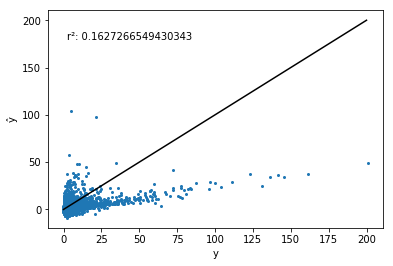

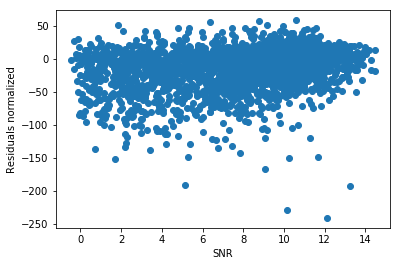

In [ ]:
loss, weights_sgd = gradient_descent(tx_train, y_train, gd_initial_weights, 1000, 0.005)
y_compare(tx_test, y_test, weights_sgd, "GD_y-compare_simple.png")
snr_plot(tx_test, y_test, weights_sgd, unc_test, "GD_snr_simple.png")

### Visualization of the difference of regression weights

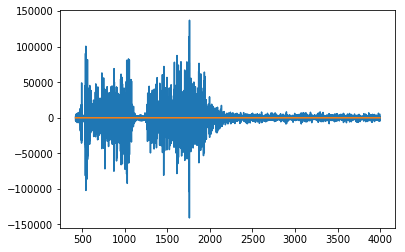

In [ ]:
plt.plot(tx_train.columns, weights_baseline)
plt.plot(tx_train.columns, weights_sgd)
# plt.yscale('log')
plt.show()

## Least-Squares with Cross-validation

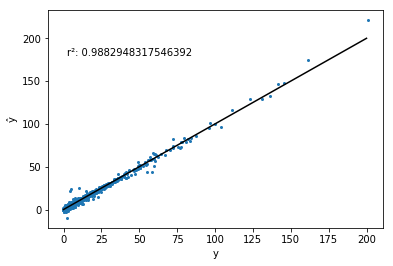

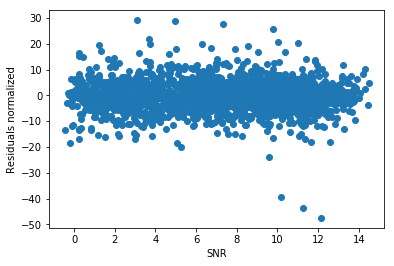

Loss is 1.12507990409526


In [ ]:
kf = KFold(n_splits=10, shuffle=True)
losses, ws = [],[]
for ind_tr, ind_te in kf.split(tx_train):
    loss, w = least_squares(tx_train.iloc[ind_tr].values, 
                            y_train.iloc[ind_tr].values,
                            tx_train.iloc[ind_te].values,
                            y_train.iloc[ind_te].values)
    losses.append(loss)
    ws.append(w)

weights_cross = np.mean(np.array(ws), axis=0)
loss_cross = np.mean(losses)
y_compare(tx_test, y_test, weights_cross, "least-squares-cross-val_y-compare__simple.png")
snr_plot(tx_test, y_test, weights_cross, unc_test, "least-squares-cross-val_snr_simple.png")
save_results(OUTPUT_FILE, "least-squares with cross-validation", weights_cross, loss_cross)
print("Loss is {}".format(loss_cross))

### Visualization of the difference of regression weights

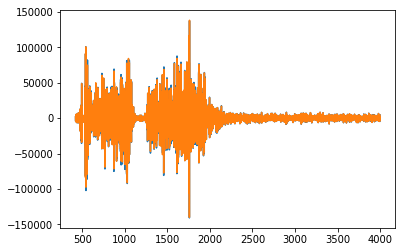

In [ ]:
plt.plot(tx_train.columns, weights_baseline)
plt.plot(tx_train.columns, weights_cross)
# plt.yscale('log')
plt.show()

## Ridge regression

# Now with augmentation of the data

In [ ]:
best_features = features_selection(tx_train, y_train, 30)
tx_train_expanded = features_expansion(tx_train, 4, best_features)
tx_test_expanded = features_expansion(tx_test, 4, best_features)

In [ ]:
%xdel tx_train
%xdel tx_test
%xdel ind_tr
%xdel ind_te

In [ ]:
loss, weights_baseline = least_squares(tx_train_expanded, y_train, tx_test_expanded, y_test)
save_results(OUTPUT_FILE, "simple least squares", weights_baseline, loss)
y_compare(tx_test_expanded, y_test, weights_baseline, "baseline_y-compare_simple.png")
snr_plot(tx_test_expanded, y_test, weights_baseline, unc_test, "baseline_snr_simple.png")

In [ ]:
kf = KFold(n_splits=10, shuffle=True)
losses, ws = [],[]
for ind_tr, ind_te in kf.split(tx_train):
    loss, w = least_squares(tx_train_expanded.iloc[ind_tr].values, 
                            y_train.iloc[ind_tr].values,
                            tx_train_expanded.iloc[ind_te].values,
                            y_train.iloc[ind_te].values)
    losses.append(loss)
    ws.append(w)

weights_cross = np.mean(np.array(ws), axis=0)
loss_cross = np.mean(losses)
y_compare(tx_test_expanded, y_test, weights_cross, "least-squares-cross-val_y-compare__simple.png")
snr_plot(tx_test_expanded, y_test, weights_cross, unc_test, "least-squares-cross-val_snr_simple.png")
save_results(OUTPUT_FILE, "least-squares with cross-validation", weights_cross, loss_cross)
print("Loss is {}".format(loss_cross))

In [ ]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)